# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=30,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_12-44-19/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5225 | MulticlassF1Score=0.0692
Batch-30 : CrossEntropyLoss=2.4628 | MulticlassF1Score=0.1628
Batch-45 : CrossEntropyLoss=2.4376 | MulticlassF1Score=0.1973
Batch-60 : CrossEntropyLoss=2.4330 | MulticlassF1Score=0.2290
Batch-75 : CrossEntropyLoss=2.4575 | MulticlassF1Score=0.2555
Batch-90 : CrossEntropyLoss=2.4470 | MulticlassF1Score=0.2749
Batch-105: CrossEntropyLoss=2.4400 | MulticlassF1Score=0.2902
Batch-120: CrossEntropyLoss=2.4592 | MulticlassF1Score=0.3019
Batch-135: CrossEntropyLoss=2.3995 | MulticlassF1Score=0.3144
Batch-150: CrossEntropyLoss=2.3871 | MulticlassF1Score=0.3382
Batch-165: CrossEntropyLoss=2.3588 | MulticlassF1Score=0.3608
Batch-180: CrossEntropyLoss=2.3778 | MulticlassF1Score=0.3801
Batch-195: CrossEntropyLoss=2.3712 | MulticlassF1Score=0.3956
Batch-210: CrossEntropyLoss=2.3735 | MulticlassF1Score=0.4089
Batch-225: CrossEntropyLoss=2.3750 | MulticlassF1Score=0.4215
Batch-226: CrossEntropyLoss=2.3440 | MulticlassF1Score=0.4220

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3589 | MulticlassF1Score=0.5969
Batch-30 : CrossEntropyLoss=2.3642 | MulticlassF1Score=0.5967
Batch-45 : CrossEntropyLoss=2.3626 | MulticlassF1Score=0.5948
Batch-60 : CrossEntropyLoss=2.3644 | MulticlassF1Score=0.5916
Batch-63 : CrossEntropyLoss=2.3752 | MulticlassF1Score=0.5914

Training   : Mean CrossEntropyLoss = 2.4365 | Mean MulticlassF1Score = 0.2817
Validation : Mean CrossEntropyLoss = 2.3754 | Mean MulticlassF1Score = 0.5948

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3651 | MulticlassF1Score=0.5936
Batch-30 : CrossEntropyLoss=2.3876 | MulticlassF1Score=0.5933
Batch-45 : CrossEntropyLoss=2.3842 | MulticlassF1Score=0.5970
Batch-60 : CrossEntropyLoss=2.3662 | MulticlassF1Score=0.5984
Batch-75 : CrossEntropyLoss=2.3540 | MulticlassF1Score=0.5989
Batch-90 : CrossEntropyLoss=2.3669 | MulticlassF1Score=0.5974
Batch-105: CrossEntropyLoss=2.3363 | MulticlassF1Score=0.6075
Batch-120: CrossEntropyLoss=2.3551 | MulticlassF1Score=0.6138
Batch-135: CrossEntropyLoss=2.3419 | MulticlassF1Score=0.6210
Batch-150: CrossEntropyLoss=2.3290 | MulticlassF1Score=0.6296
Batch-165: CrossEntropyLoss=2.3506 | MulticlassF1Score=0.6367
Batch-180: CrossEntropyLoss=2.3188 | MulticlassF1Score=0.6445
Batch-195: CrossEntropyLoss=2.3401 | MulticlassF1Score=0.6502
Batch-210: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.6552
Batch-225: CrossEntropyLoss=2.3310 | MulticlassF1Score=0.6595
Batch-226: CrossEntropyLoss=2.3405 | MulticlassF1Score=0.6596

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7171
Batch-30 : CrossEntropyLoss=2.3384 | MulticlassF1Score=0.7188
Batch-45 : CrossEntropyLoss=2.3332 | MulticlassF1Score=0.7171
Batch-60 : CrossEntropyLoss=2.3326 | MulticlassF1Score=0.7195
Batch-63 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7193

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3539 | Mean MulticlassF1Score = 0.6177
Validation : Mean CrossEntropyLoss = 2.3354 | Mean MulticlassF1Score = 0.7196

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7460
Batch-30 : CrossEntropyLoss=2.3295 | MulticlassF1Score=0.7558
Batch-45 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7628
Batch-60 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7651
Batch-75 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7670
Batch-90 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7692
Batch-105: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7715
Batch-120: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7740
Batch-135: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7764
Batch-150: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7778
Batch-165: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7800
Batch-180: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7810
Batch-195: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7817
Batch-210: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7819
Batch-225: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7823
Batch-226: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7823

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7891
Batch-30 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7919
Batch-45 : CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7935
Batch-60 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7929
Batch-63 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7933

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3158 | Mean MulticlassF1Score = 0.7690
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7922

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7943
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8016
Batch-45 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8033
Batch-60 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8041
Batch-75 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8051
Batch-90 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8063
Batch-105: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8074
Batch-120: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8064
Batch-135: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8058
Batch-150: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8064
Batch-165: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8067
Batch-180: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8070
Batch-195: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8072
Batch-210: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8067
Batch-225: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.8066
Batch-226: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8066

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.8063
Batch-30 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8079
Batch-45 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8065
Batch-60 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8074
Batch-63 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3077 | Mean MulticlassF1Score = 0.8043
Validation : Mean CrossEntropyLoss = 2.3079 | Mean MulticlassF1Score = 0.8057

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8044
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8088
Batch-45 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.8101
Batch-60 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8118
Batch-75 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8101
Batch-90 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8107
Batch-105: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8097
Batch-120: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8096
Batch-135: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8094
Batch-150: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.8091
Batch-165: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.8092
Batch-180: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.8098
Batch-195: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8101
Batch-210: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8099
Batch-225: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8099
Batch-226: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8100

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8083
Batch-30 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8073
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8072
Batch-60 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8068
Batch-63 : CrossEntropyLoss=2.3216 | MulticlassF1Score=0.8063

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3064 | Mean MulticlassF1Score = 0.8094
Validation : Mean CrossEntropyLoss = 2.3081 | Mean MulticlassF1Score = 0.8077

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8105
Batch-30 : CrossEntropyLoss=2.3249 | MulticlassF1Score=0.8089
Batch-45 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8097
Batch-60 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8118
Batch-75 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8107
Batch-90 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.8101
Batch-105: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8109
Batch-120: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8113
Batch-135: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8107
Batch-150: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8106
Batch-165: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8111
Batch-180: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8111
Batch-195: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8112
Batch-210: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8113
Batch-225: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8114
Batch-226: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8114

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.8109
Batch-30 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8082
Batch-45 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8099
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8093
Batch-63 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8096

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3059 | Mean MulticlassF1Score = 0.8106
Validation : Mean CrossEntropyLoss = 2.3069 | Mean MulticlassF1Score = 0.8087

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8159
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8213
Batch-45 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.8226
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8241
Batch-75 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8258
Batch-90 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8270
Batch-105: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8283
Batch-120: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8292
Batch-135: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8296
Batch-150: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8303
Batch-165: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8316
Batch-180: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8316
Batch-195: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8320
Batch-210: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8322
Batch-225: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8322
Batch-226: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8289
Batch-45 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8286
Batch-60 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8291
Batch-63 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8265
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8308

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8310
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8331
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8344
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8338
Batch-75 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8320
Batch-90 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8329
Batch-105: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8331
Batch-120: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8341
Batch-135: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8343
Batch-150: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8346
Batch-165: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8347
Batch-180: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8347
Batch-195: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8350
Batch-210: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8350
Batch-225: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8346
Batch-226: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8345

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8302
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8316
Batch-45 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8301
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8298
Batch-63 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8301

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8338
Validation : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8312

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8285
Batch-30 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8311
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8331
Batch-75 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8391
Batch-90 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8420
Batch-105: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8443
Batch-120: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8468
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8513
Batch-150: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8544
Batch-165: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8577
Batch-180: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8598
Batch-195: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8618
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8635
Batch-225: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8649
Batch-226: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8818
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8808
Batch-63 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8806

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8460
Validation : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8822

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8911
Batch-75 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8897
Batch-90 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8895
Batch-105: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8896
Batch-120: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8893
Batch-135: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8894
Batch-150: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8892
Batch-165: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8890
Batch-180: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8890
Batch-195: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8885
Batch-210: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8883
Batch-225: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8884
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8884

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8853
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8826
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8835
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8840

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8895
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8836

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8914
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8898
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8900
Batch-75 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8904
Batch-90 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8909
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8915
Batch-120: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8916
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8912
Batch-150: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8907
Batch-165: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8909
Batch-180: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8910
Batch-195: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8913
Batch-210: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8915
Batch-225: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8913
Batch-226: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8912

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8868
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8853
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8852
Batch-63 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8852

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8910
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8867

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8899
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8920
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8925
Batch-90 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8928
Batch-120: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8935
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8939
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8942
Batch-180: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8936
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8936
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8934
Batch-225: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8935
Batch-226: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8935

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8847
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8855
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8863
Batch-60 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8851
Batch-63 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8855

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8925
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8849

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8990
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8978
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8969
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8956
Batch-75 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8950
Batch-90 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8948
Batch-105: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8948
Batch-120: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8948
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8948
Batch-150: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8940
Batch-165: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8946
Batch-180: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8948
Batch-195: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8949
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8949
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8950
Batch-226: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8950

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8845
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8858
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8864

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8957
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8863

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8987
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8994
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8991
Batch-75 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8990
Batch-90 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8992
Batch-105: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8984
Batch-120: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8977
Batch-135: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8975
Batch-150: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8974
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8969
Batch-180: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8971
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8973
Batch-210: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8970
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8966
Batch-226: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8965

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8884
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8853
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8848
Batch-60 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8863
Batch-63 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8859

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8982
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8866

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8978
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8978
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8989
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8985
Batch-75 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8983
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8990
Batch-105: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8993
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8992
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8984
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8988
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8989
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8990
Batch-195: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8991
Batch-210: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8994
Batch-225: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8988
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8988

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8906
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8894
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8893

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8990
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8890

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9031
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9032
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9029
Batch-75 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9019
Batch-90 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9023
Batch-105: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9021
Batch-120: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9029
Batch-135: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9031
Batch-150: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9029
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9034
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9035
Batch-195: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.9034
Batch-210: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9031
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9030
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9030

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8956
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8936
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8916
Batch-63 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8905

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.9029
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8934

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9064
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9048
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9041
Batch-90 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9041
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9044
Batch-120: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9040
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9039
Batch-150: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9041
Batch-165: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9041
Batch-180: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9043
Batch-195: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9041
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9042
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8932
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8919
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8914
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8912

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9043
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8921

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9092
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.9069
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9055
Batch-75 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9060
Batch-90 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9052
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9043
Batch-120: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9044
Batch-135: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9044
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9054
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9054
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9053
Batch-210: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9053
Batch-225: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9052
Batch-226: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9052

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8926
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8903
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8922
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8921
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8923

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2768 | Mean MulticlassF1Score = 0.9056
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8918

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9086
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9092
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9098
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9090
Batch-75 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9088
Batch-90 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9085
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9081
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9079
Batch-135: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9071
Batch-150: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9065
Batch-180: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9063
Batch-195: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9061
Batch-210: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9059
Batch-225: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9061
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8914
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.8925
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8919

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9075
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8905

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9110
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9096
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9090
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9093
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9095
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9109
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9133
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9148
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9161
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9174
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9184
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9193
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9203
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9210
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9215
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9215

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9179
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9180

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9144
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9203

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9316
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9340
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9341
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9341
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9346
Batch-120: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9349
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9348
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9350
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9351
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9348
Batch-195: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9345
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9347
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9344
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9344

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9341
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9222

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9334
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9346
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9353
Batch-90 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9352
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9364
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9368
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9364
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9212

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9208

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9370
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9372
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9372
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9199

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9373
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9375
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9379
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9379
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9378
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9212

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9211

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9387
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9384
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9384
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9208

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9395
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9388
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9388
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9390
Batch-210: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9388
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9386
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9386

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9399
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9198

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9387
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9389
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9392
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9392
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9187
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9210

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9417
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9407

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9546
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9568
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9584
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9592
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9595
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9596
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9589
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9588
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9587
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9589
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9592
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9591
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9590
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9592
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9422
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9422

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9432

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9602
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9612
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9589
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9594
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9591
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9599
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9599
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9599
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9598
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9599
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9597
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9597

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9417
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9419

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9407

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9594
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9609
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9606
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9602
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9604
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9608
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9605
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9606
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9606
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9605
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9604
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9605
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9606
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9606
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9607
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9607

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9430
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9430

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9604
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9435

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9616
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9604
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9617
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9618
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9623
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9629
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9625
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9624
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9623
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9623
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9621

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9444
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9439

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9613
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9637
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9634
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9630
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9634
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9629
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9626
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9627
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9627

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9439

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9614
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9631
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9632
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9633
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9634
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9634
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9631
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9631
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9631

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9450

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9633
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9448

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9637
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9637
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9643
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9635
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9635
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9636

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9441

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9632
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9451

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9641
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9455

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9624
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9631
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9638
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9639
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9643
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9644
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9644
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9454

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9643
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9646
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9655
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9454

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9660
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9476

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9456

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9654
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9476

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9470

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9479
Patience = 1/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9466

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9483

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9475

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9484

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9498
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9500

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9485

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9510
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9505

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9500

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9501

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9496

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2630
Best MulticlassF1Score validation : 0.9705
Best MulticlassF1Score validation : 0.9496
Training duration                 : 2.7551 minutes.
Training date                     : 2022-10-19 09:07:39.028562+08:00


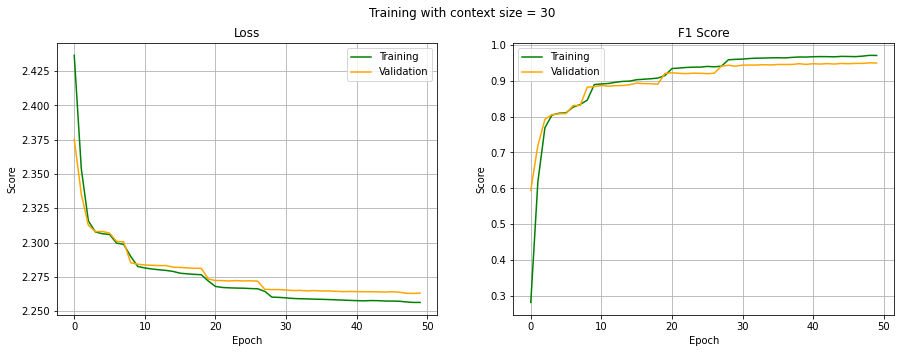

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9501, device='cuda:0'),
 tensor(0.9487, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9501, device='cuda:0'),
 tensor(0.9487, device='cuda:0'))

## Heatmap

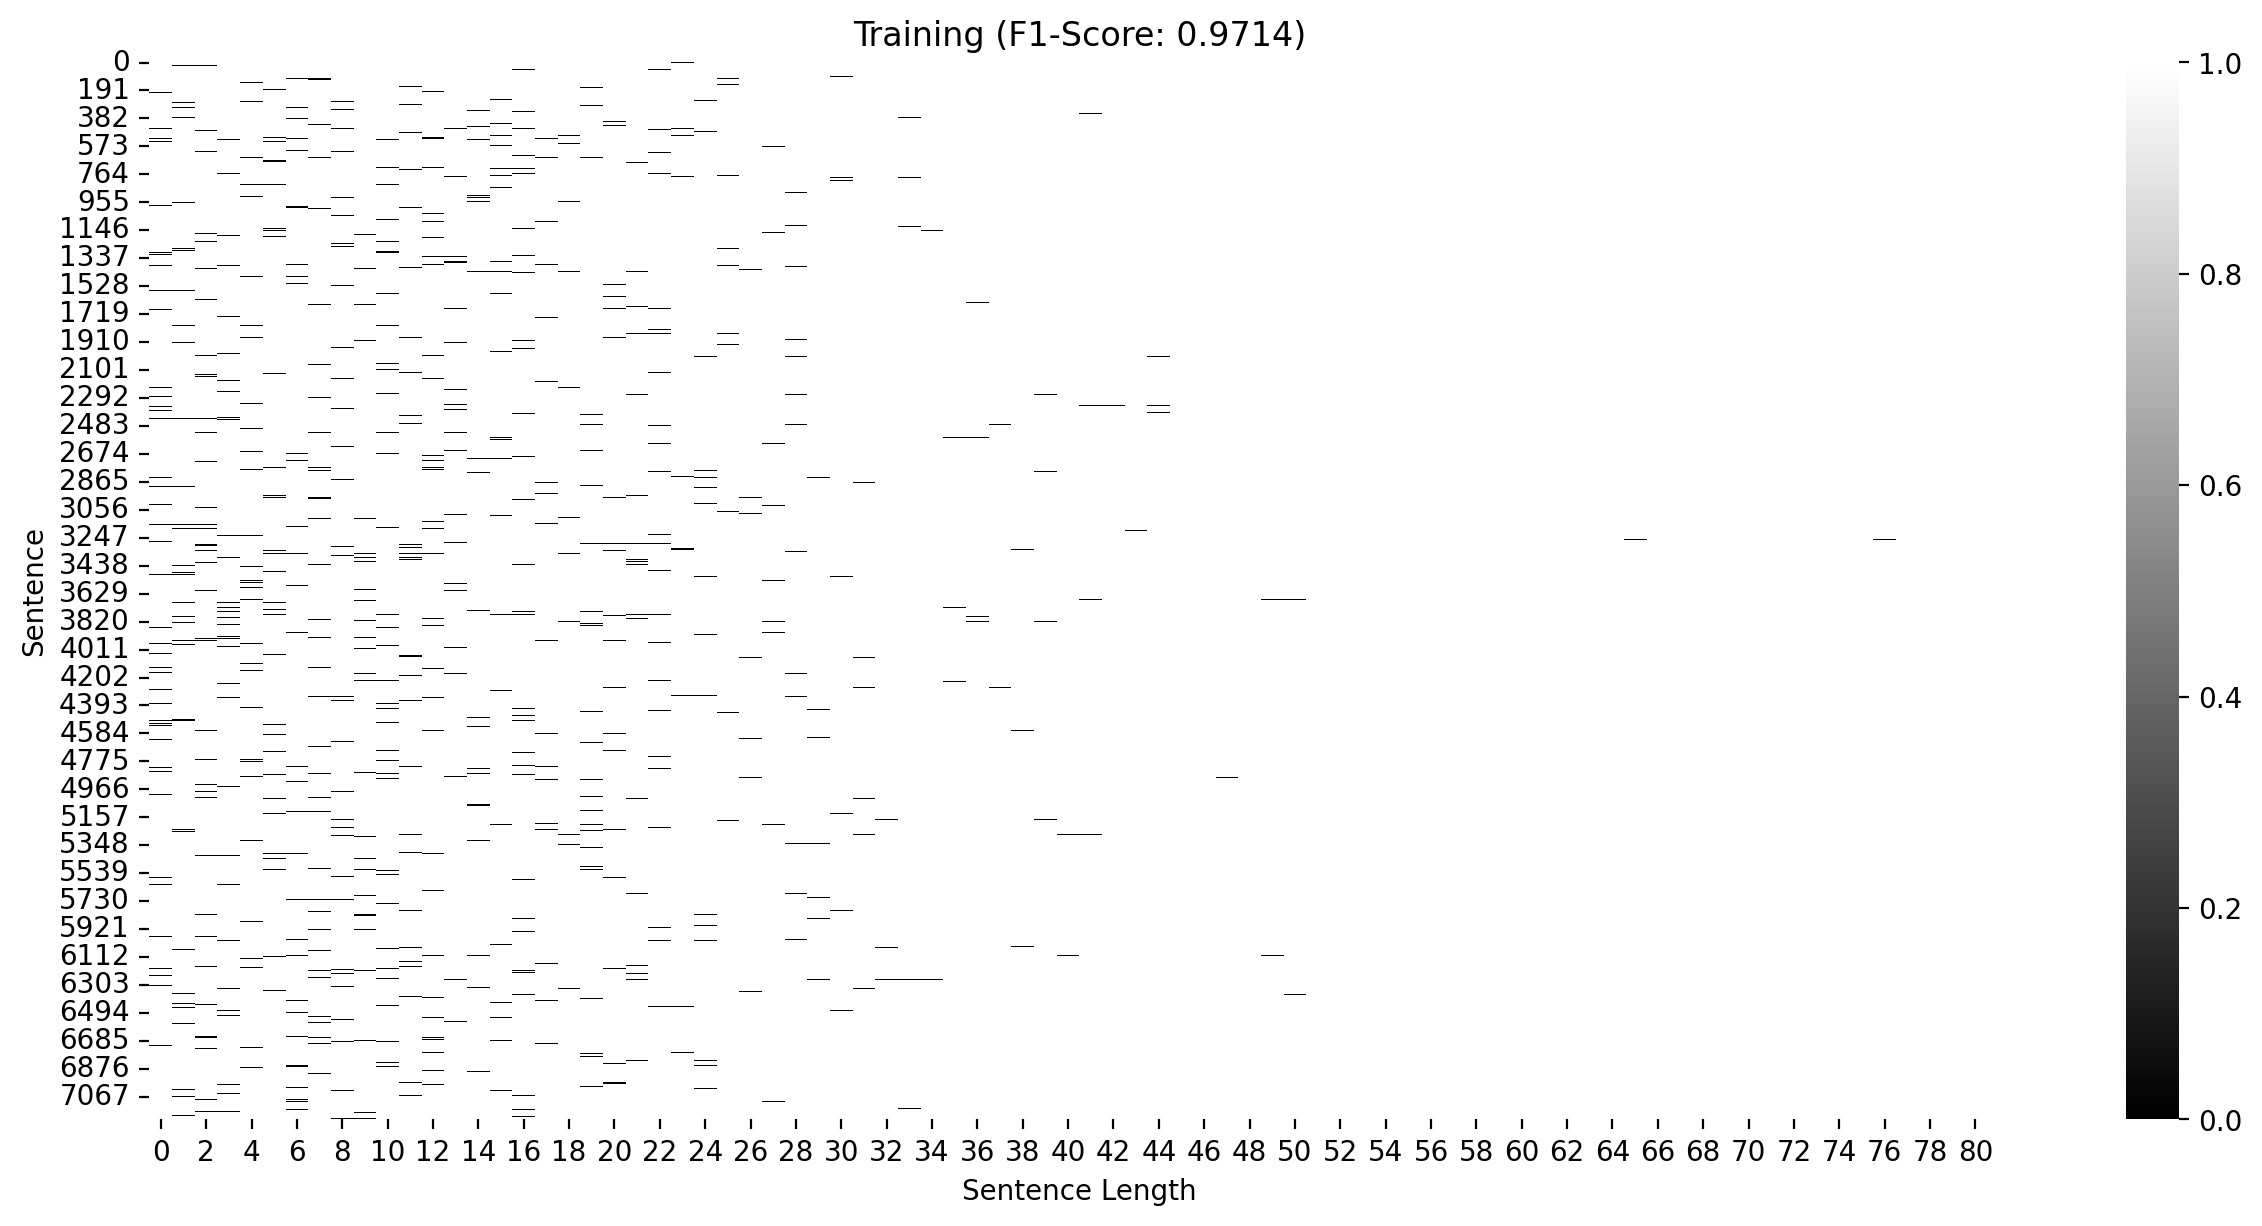

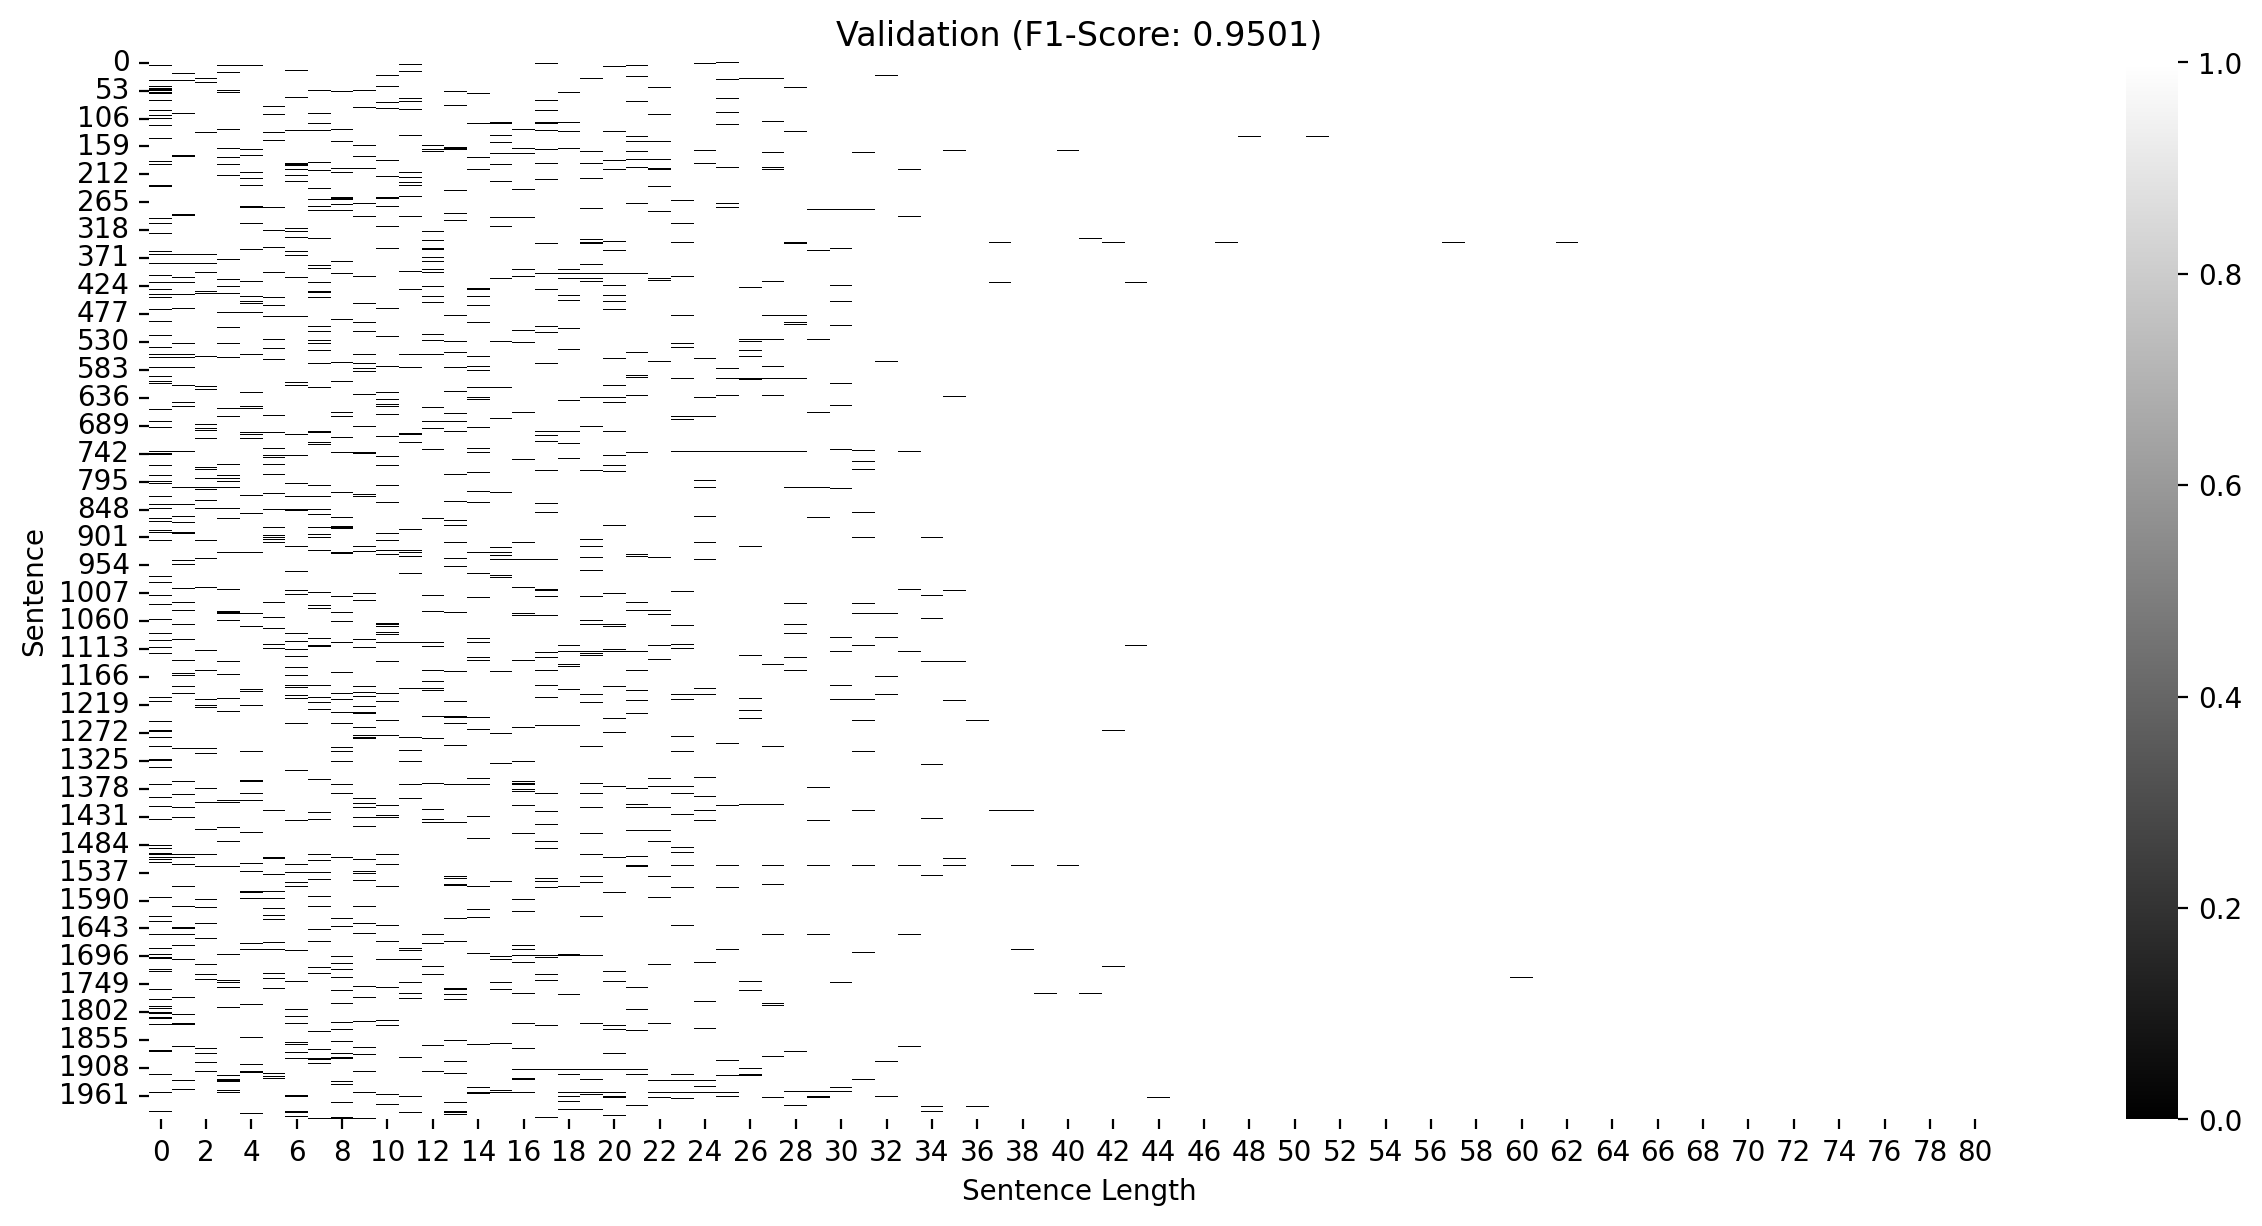

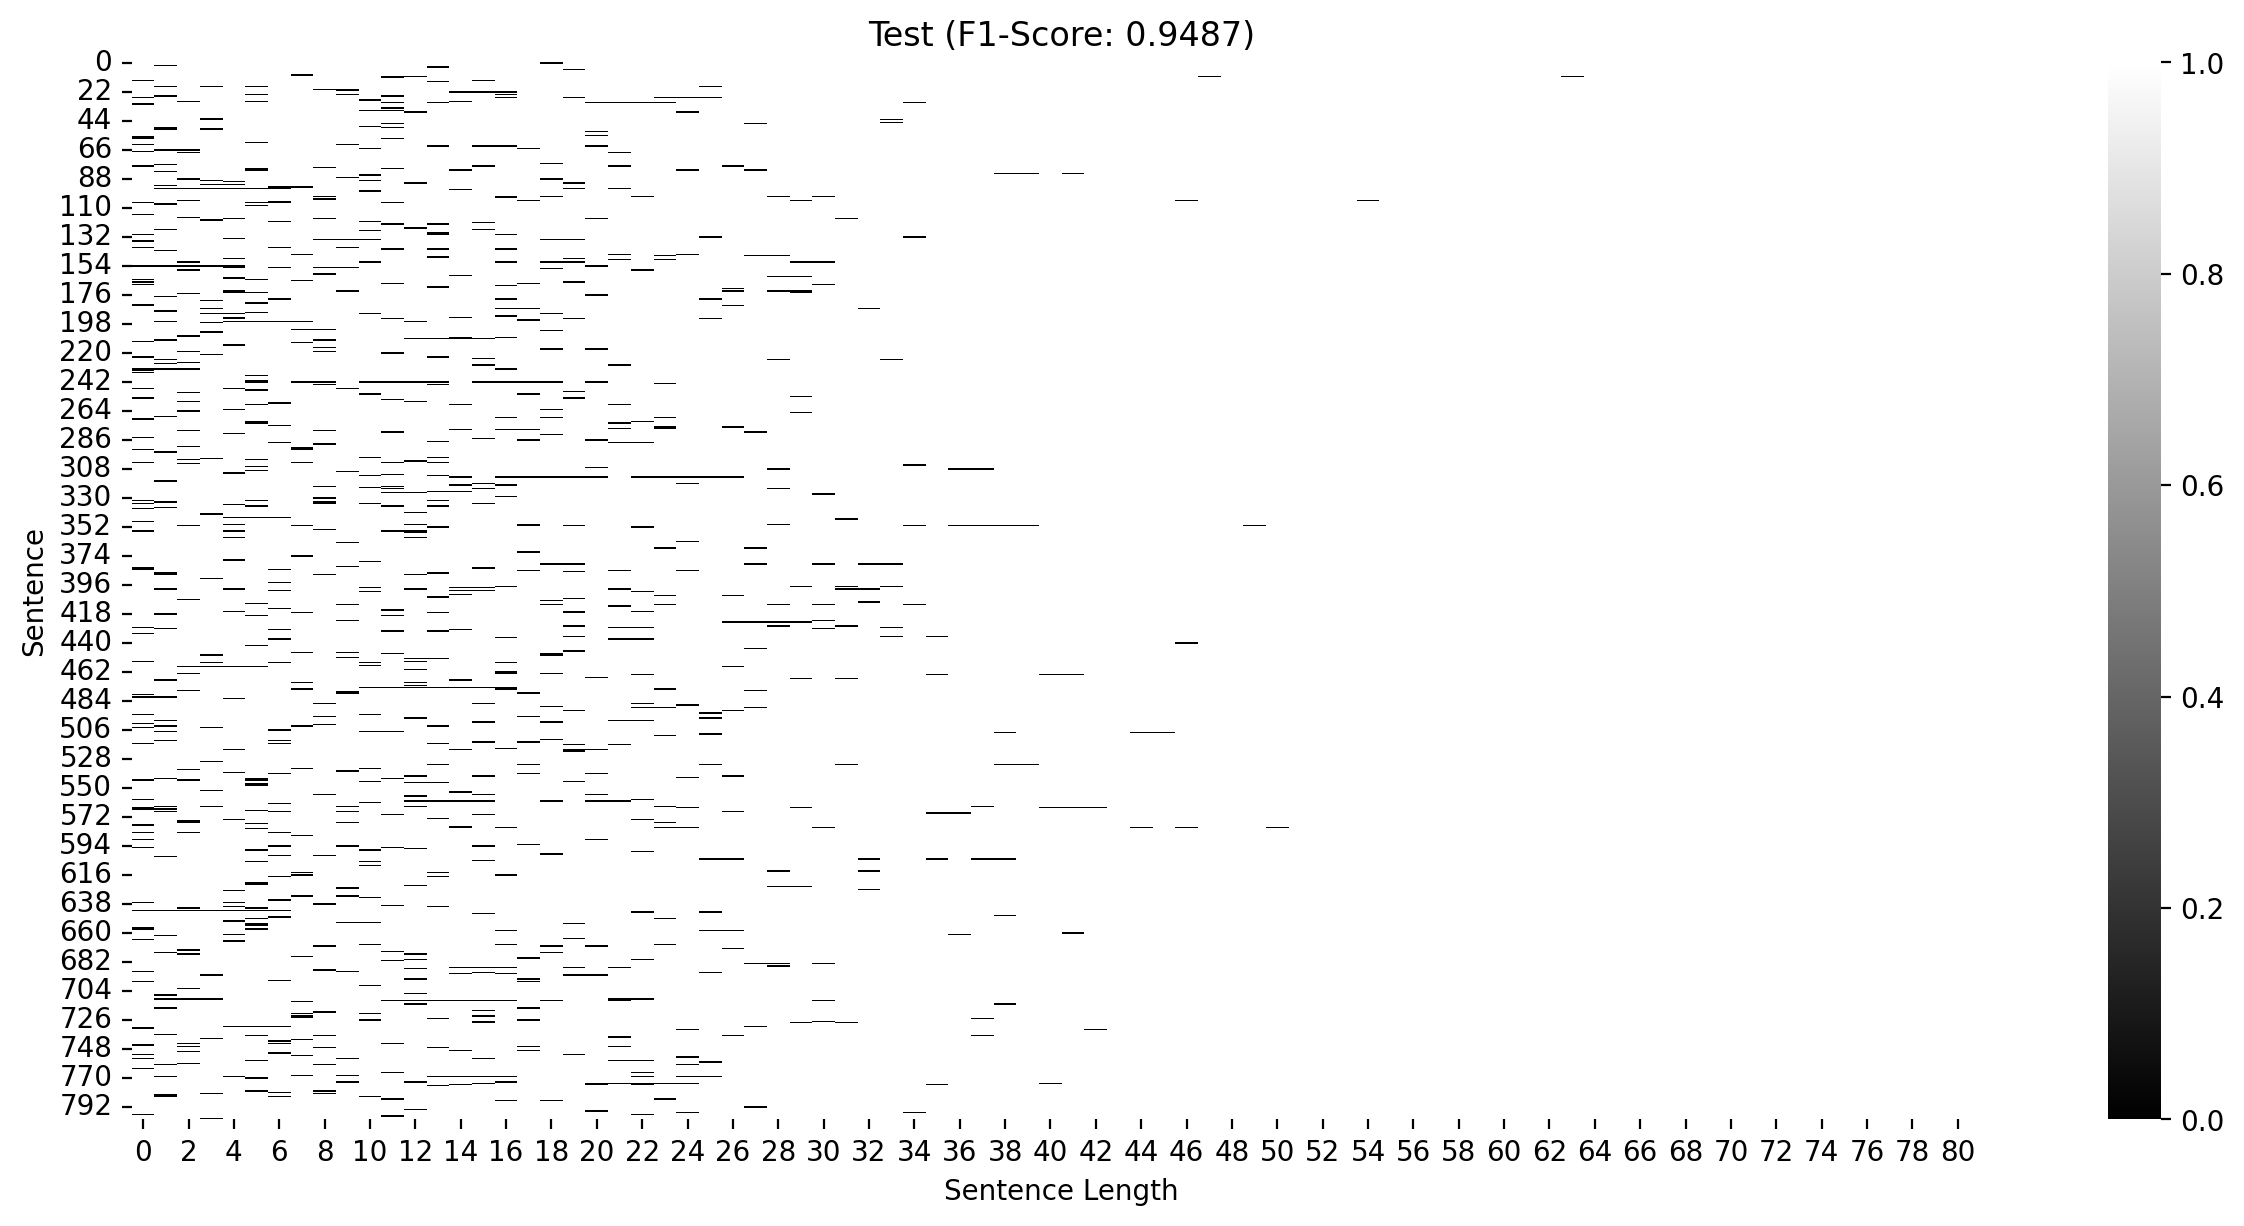

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


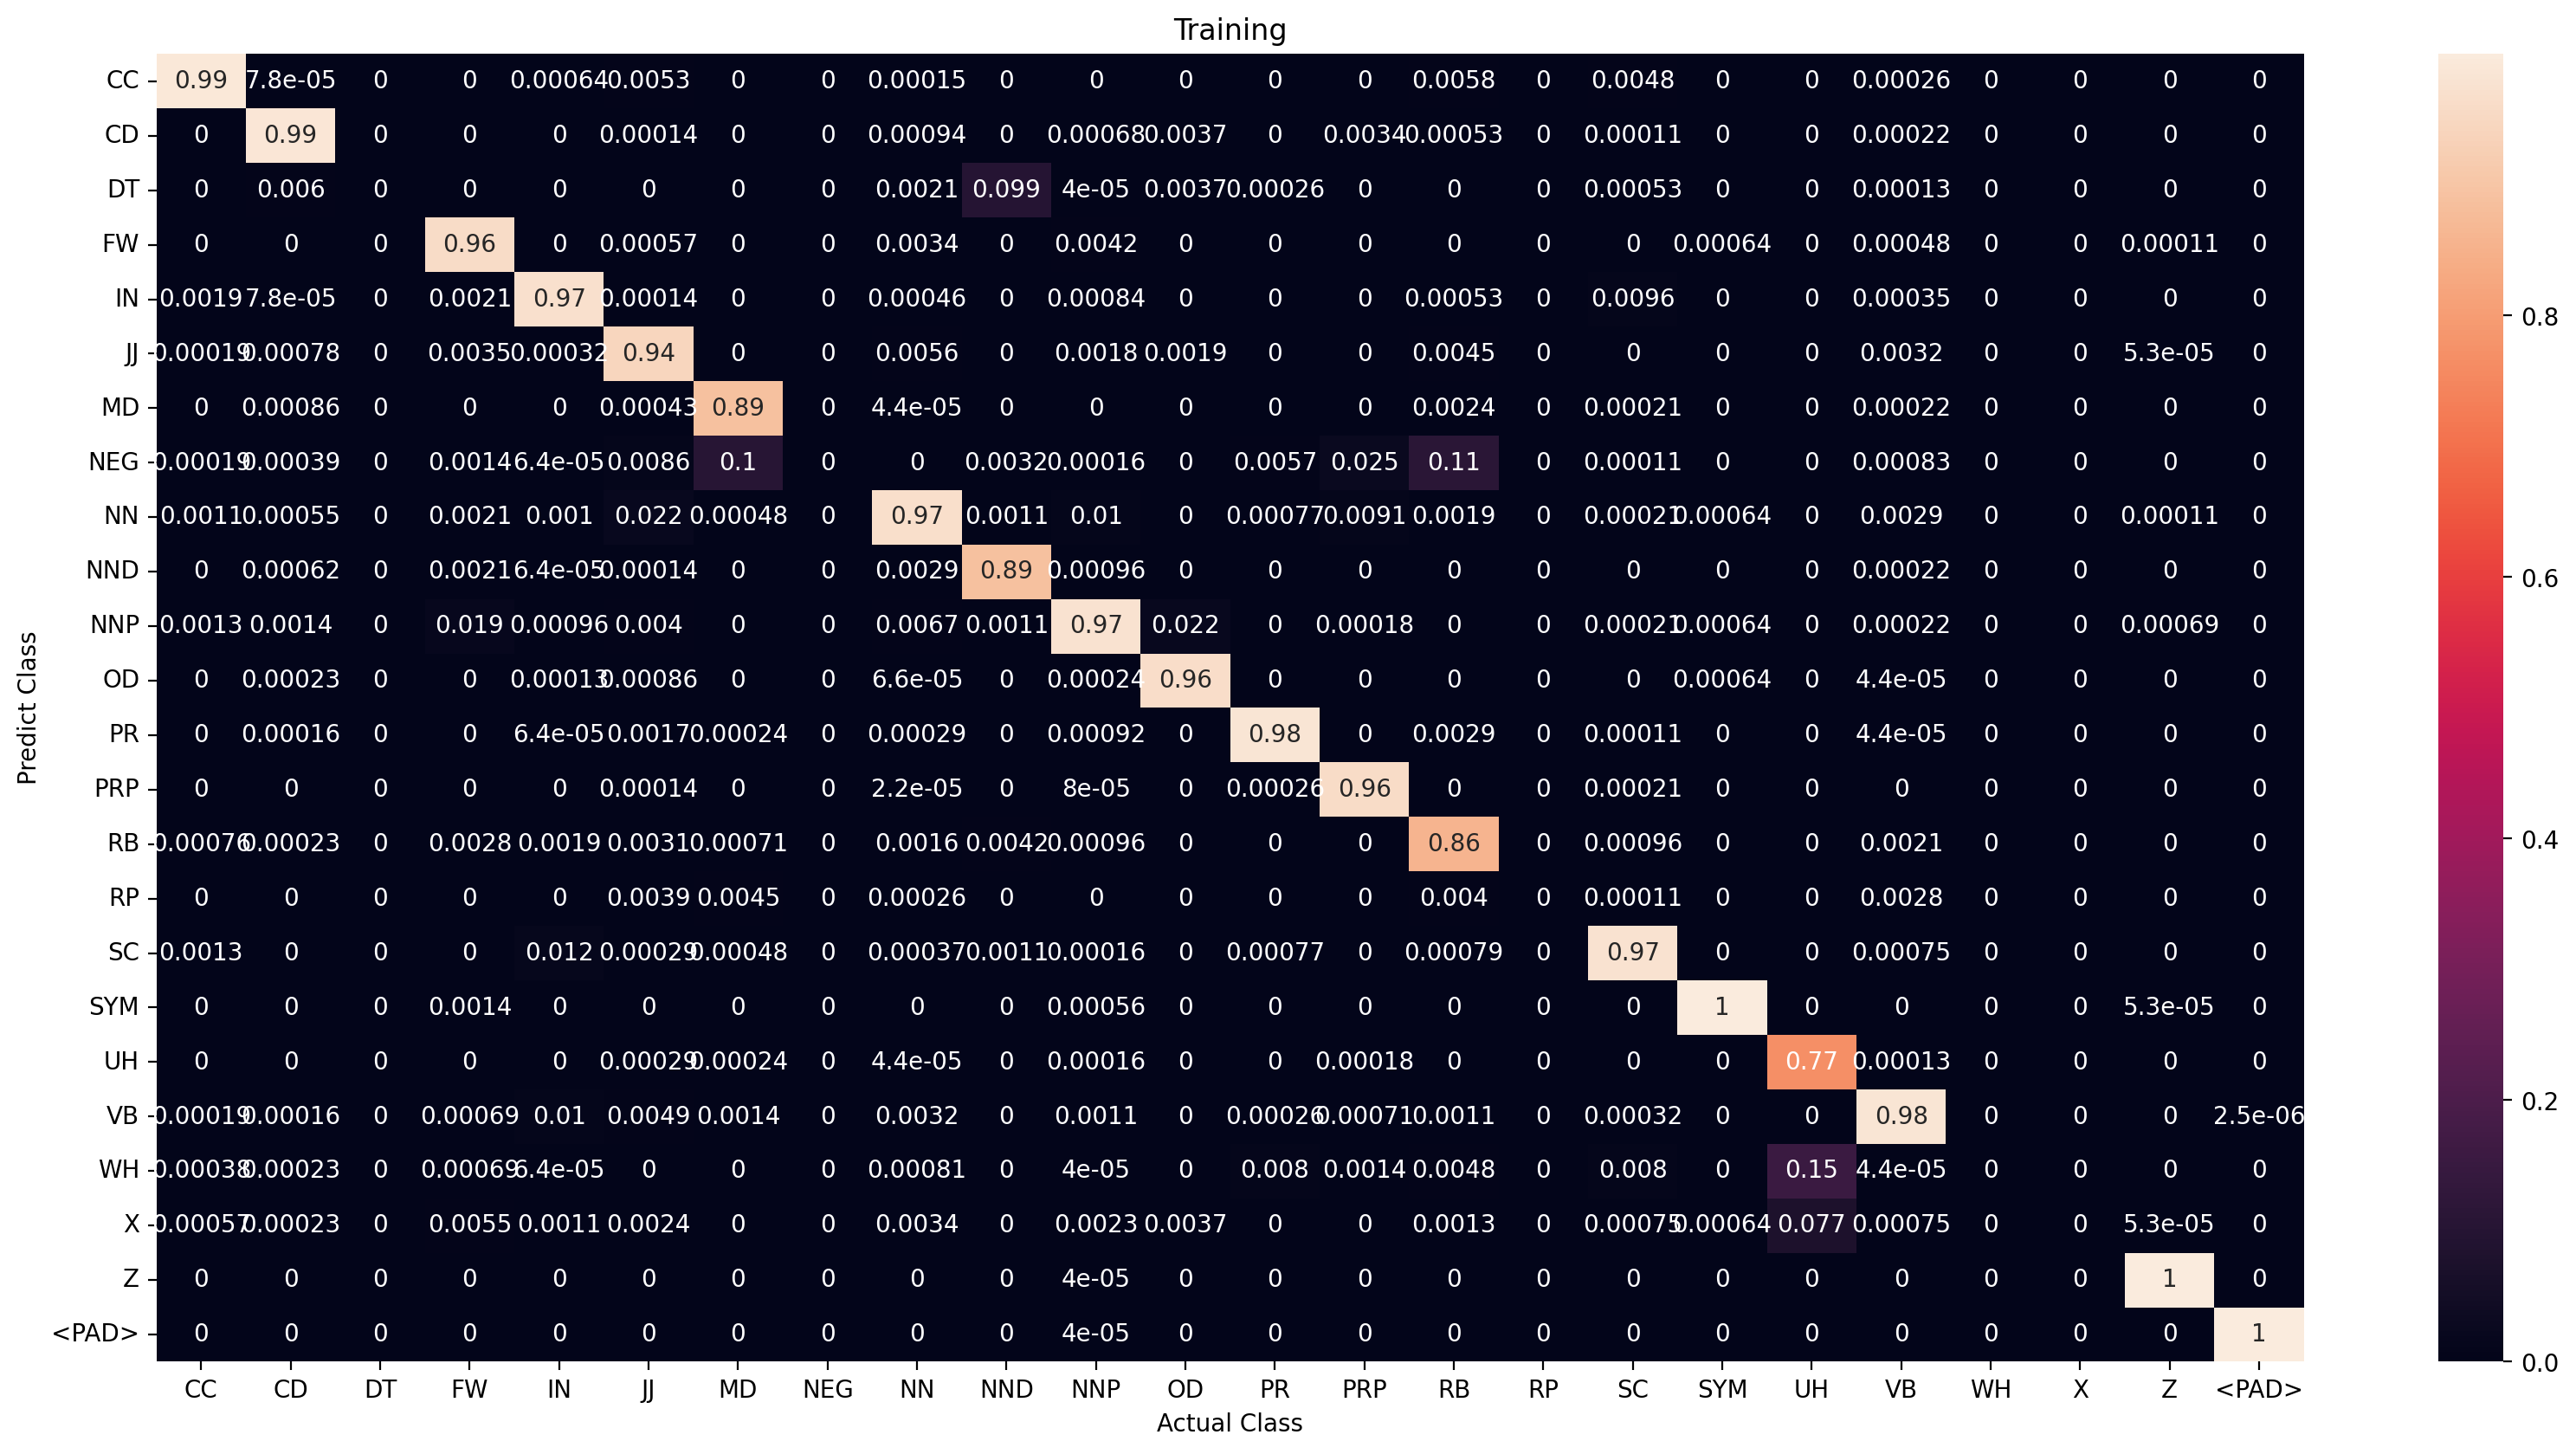

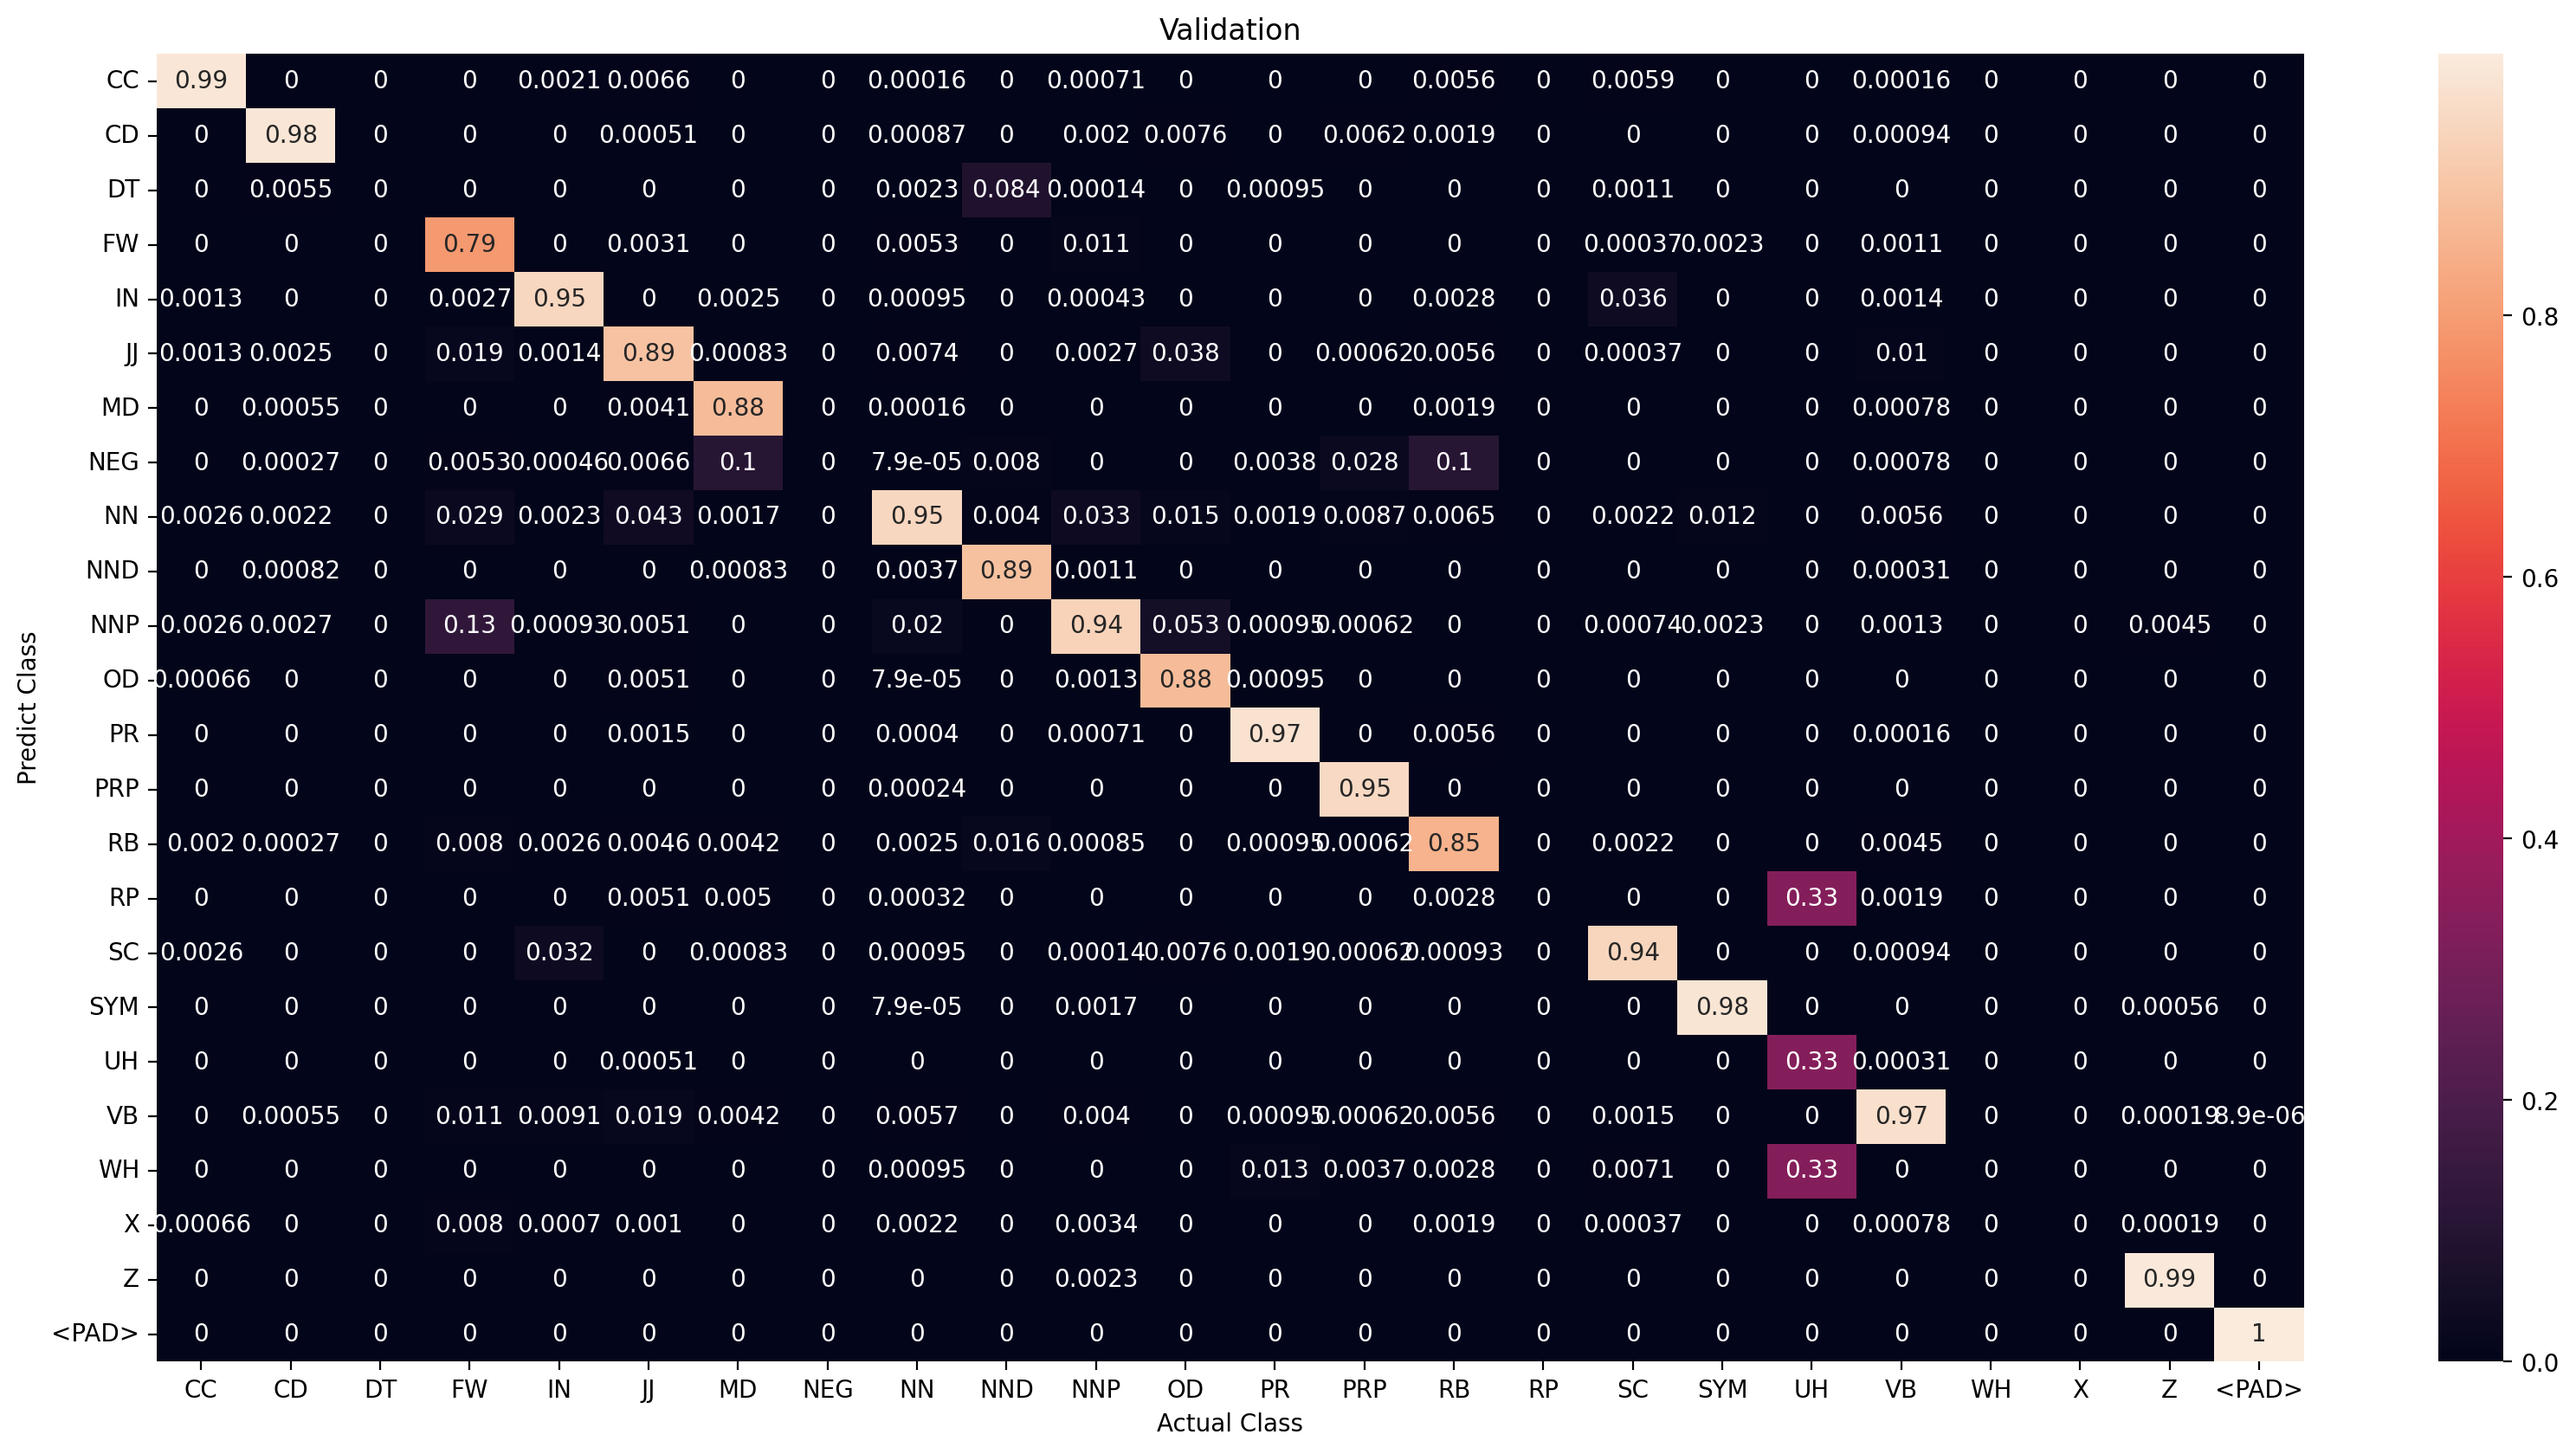

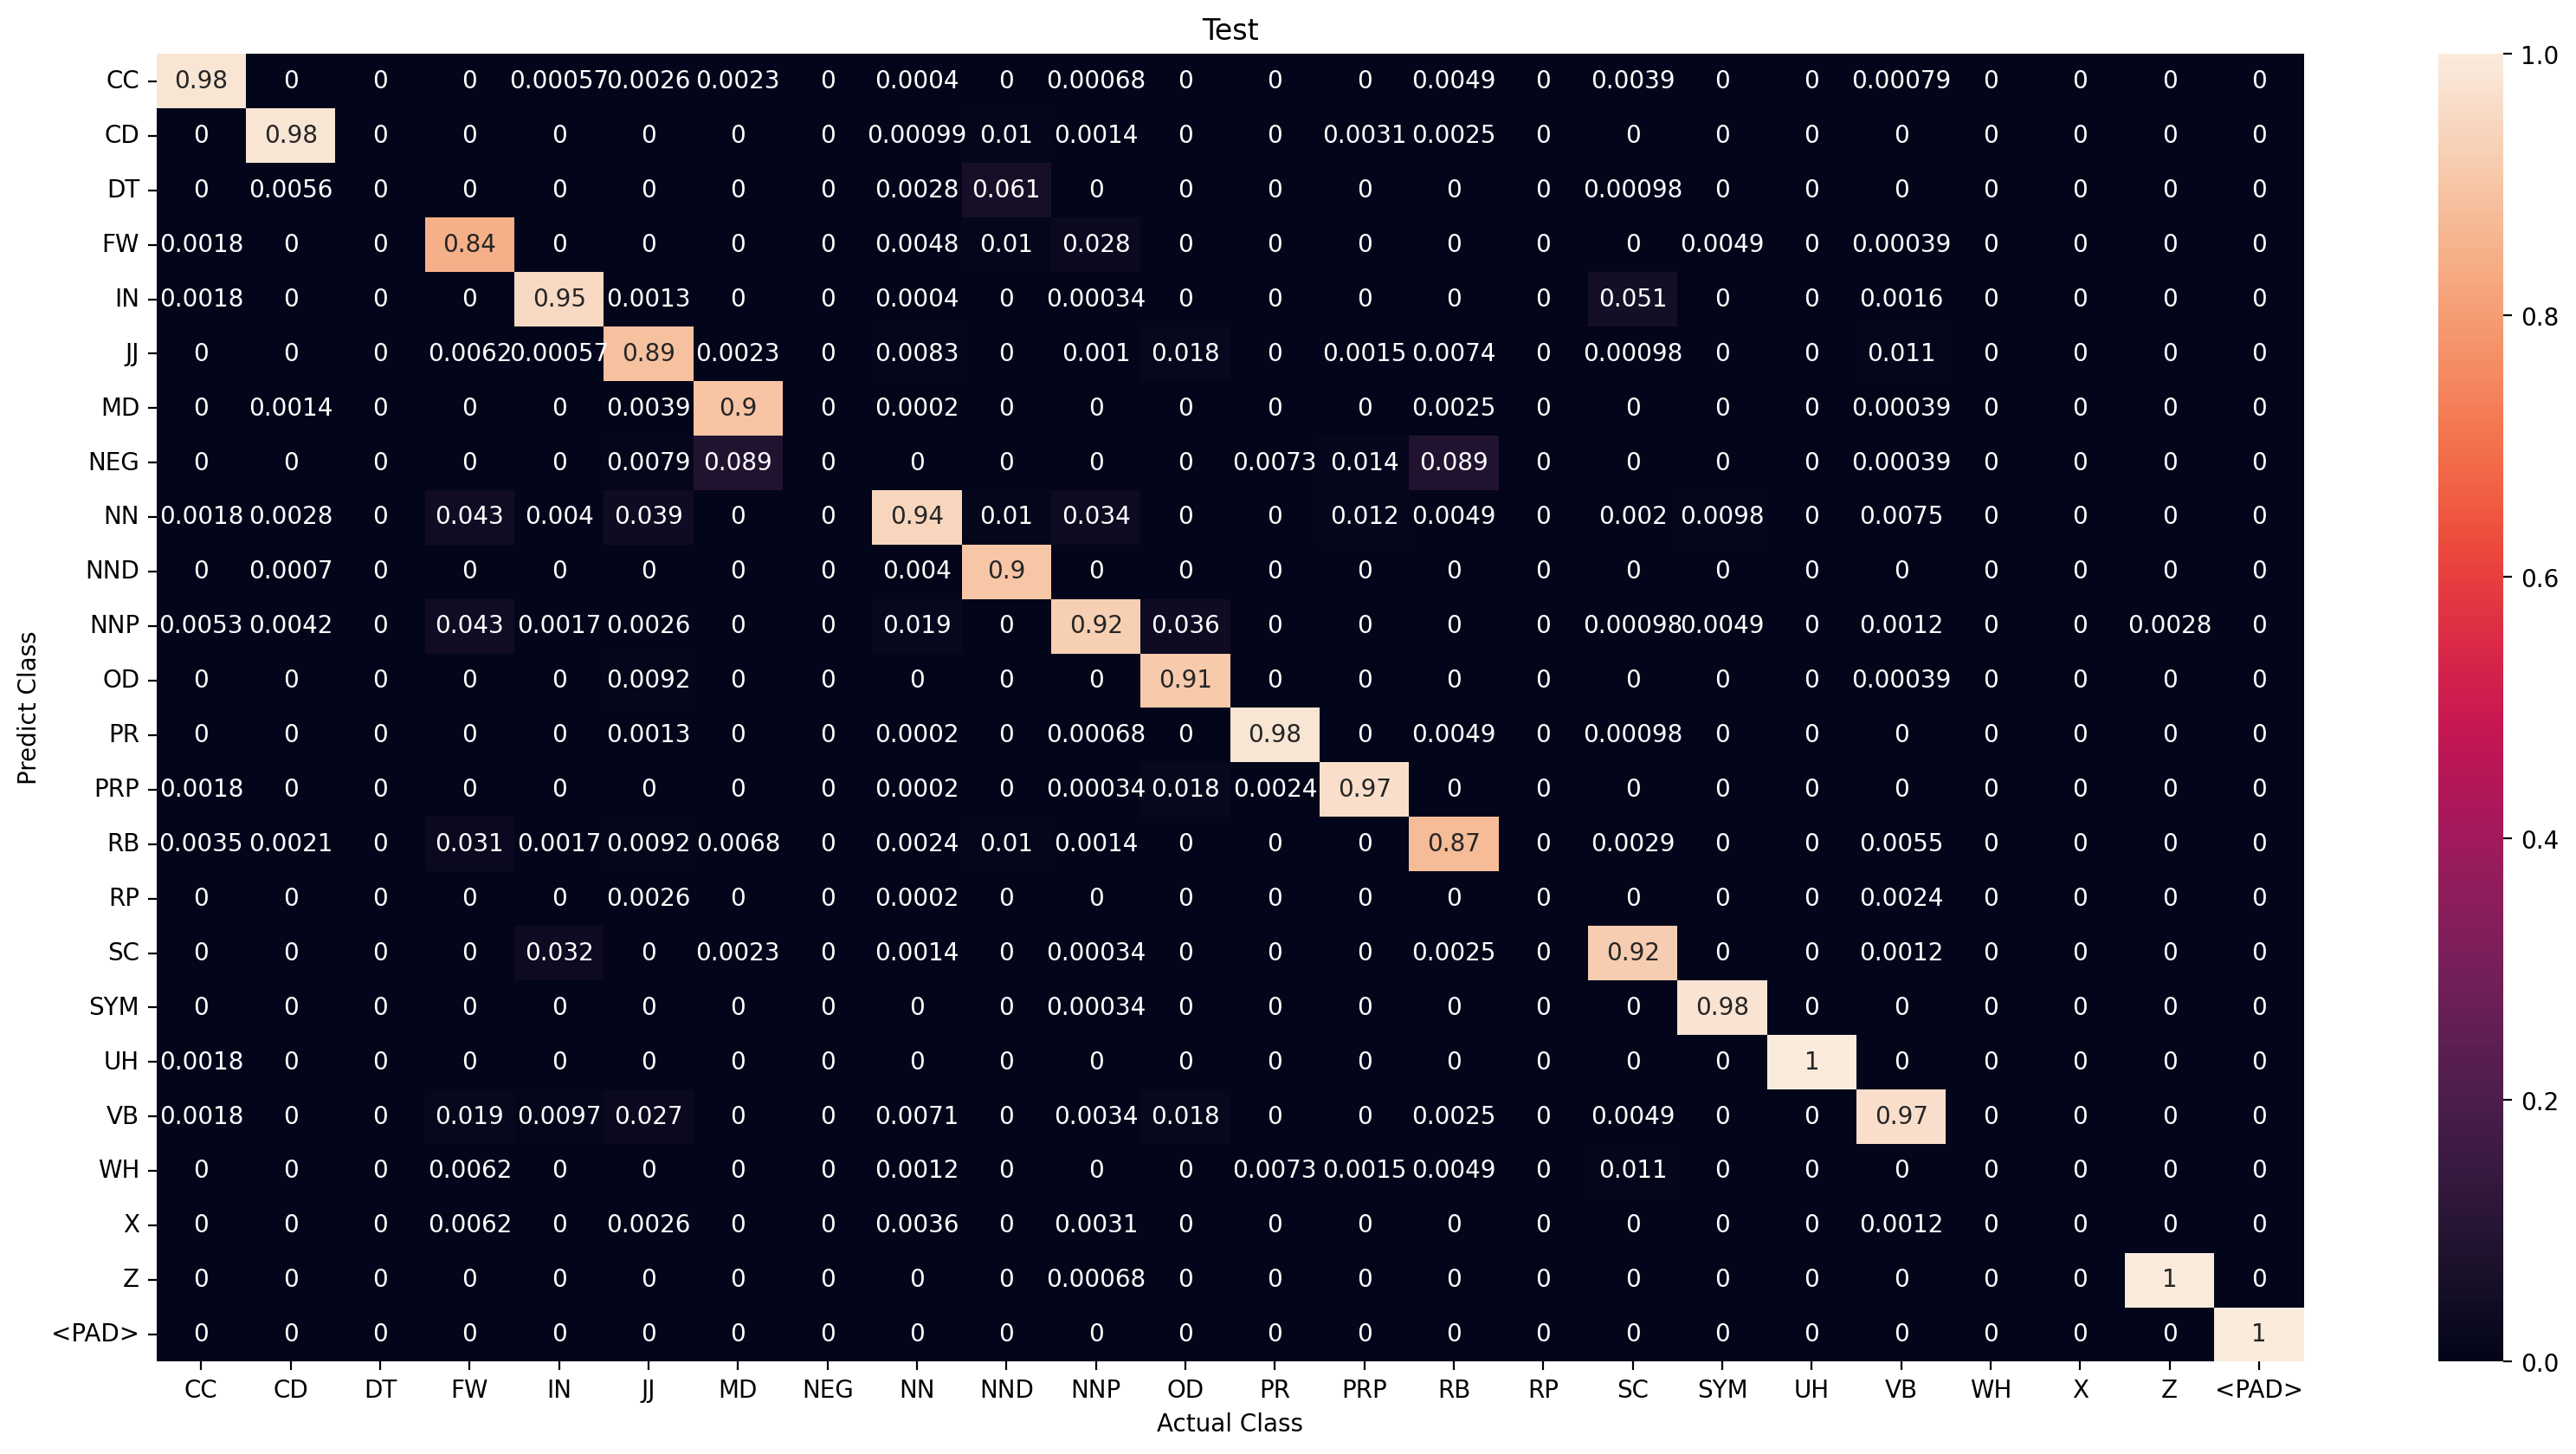

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5194       | CC    : 128      |
| CD    : 12758  | CD    : 12668      | CD    : 90       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1389       | FW    : 277      |
| IN    : 15371  | IN    : 15214      | IN    : 157      |
| JJ    : 6997   | JJ    : 6582       | JJ    : 415      |
| MD    : 3774   | MD    : 3742       | MD    : 32       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44099      | NN    : 573      |
| NND   : 1021   | NND   : 846        | NND   : 175      |
| NNP   : 24845  | NNP   : 24408      | NNP   : 437      |
| OD    : 541    | OD    : 519        | OD    : 22       |
| PR    : 3896   | PR    : 3831       | PR    : 65       |
| PRP   : 5408   | PRP   : 5401       | PRP   : 7        |
| RB    : 3463   | RB    : 3241       | RB    : 222      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11063
Wrong prediction            : 758
Percentage correct oov pred : 93.58768293714576

Validation
Number OOV token            : 3350
Correct prediction          : 2961
Wrong prediction            : 389
Percentage correct oov pred : 88.38805970149254

Test
Number OOV token            : 1391
Correct prediction          : 1236
Wrong prediction            : 155
Percentage correct oov pred : 88.85693745506829



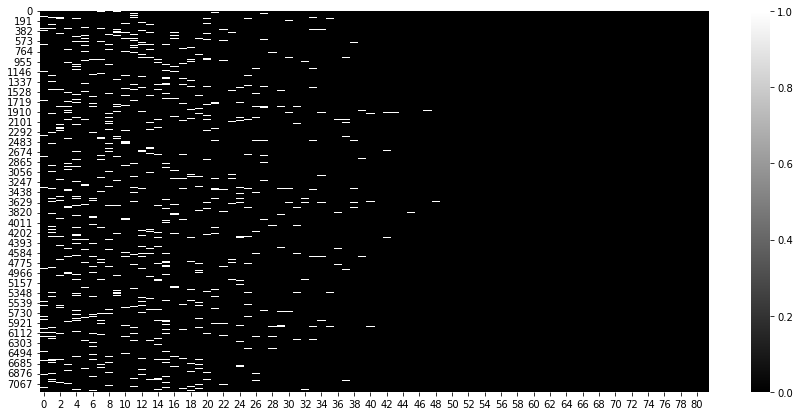

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

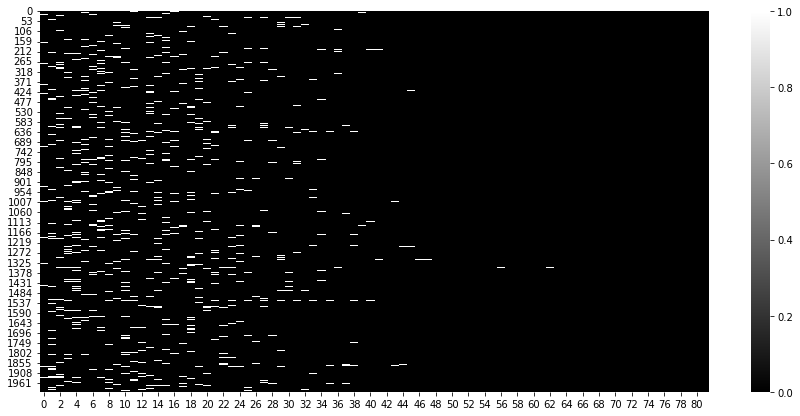

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

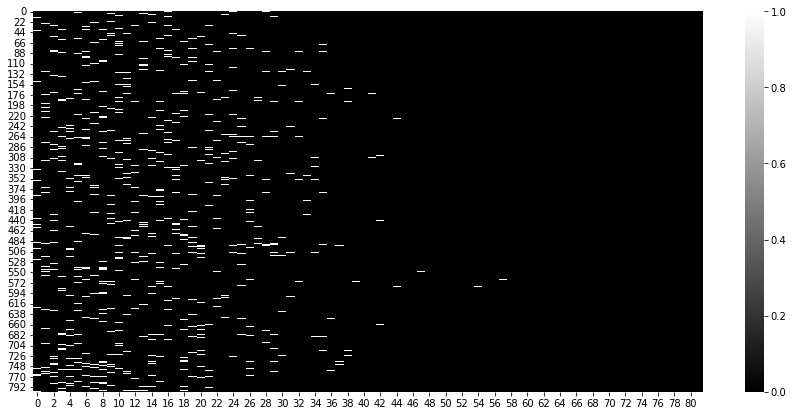

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);